In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from dyck_k_generator import constants

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
torch.manual_seed(42)

In [6]:
k = 1

In [7]:
from dyck_k_generator.generator import generate_dataset

path = generate_dataset(
    n=15_000,
    k=k,
    min_length=8,
    max_length=16,
    balanced=0.5,
)

File data/dyck-1_15000-samples_16-len_p05.jsonl already exists.


In [8]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()'

In [9]:
from dataset.dataset import DyckLanguageDataset

In [10]:
dataset = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 15000 samples from data/dyck-1_15000-samples_16-len_p05.jsonl


Tokenizing strings: 100%|██████████| 15000/15000 [00:00<00:00, 154982.97it/s]


In [11]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [12]:
from torch.utils.data import DataLoader

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Manual Transformer + BERTViz


In [16]:
from transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    pad_token_mask,
)

In [17]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=512,
    n_layers=2,
    n_classes=2,
    max_seq_len=16,
)

In [18]:
model_bidirectional = TransformerClassifier(model_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasmolinolo. Use `wandb login --relogin` to force relogin


In [19]:
model_bidirectional.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=512, out_features=256, bias=True)
        )
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((2

In [20]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_bidirectional.parameters(), lr=1e-5)

In [21]:
train_loss, train_acc, val_loss, val_acc = model_bidirectional.train_model(
    device=device,
    epochs=10,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.1445 | Train Accuracy: 82.53%
Train Loss: 0.0179 | Train Accuracy: 91.25%
Train Loss: 0.0081 | Train Accuracy: 94.17%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.1397 | Validation Accuracy: 100.00%
Validation Loss: 0.2809 | Validation Accuracy: 100.00%
Train Loss: 51.8860 | Train Acc: 95.33%
Val Loss: 0.3161 | Val Acc: 100.00%
Epoch 2/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0031 | Train Accuracy: 100.00%
Train Loss: 0.0019 | Train Accuracy: 100.00%
Train Loss: 0.0013 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0280 | Validation Accuracy: 100.00%
Validation Loss: 0.0561 | Validation Accuracy: 100.00%
Train Loss: 0.9061 | Train Acc: 100.00%
Val Loss: 0.0630 | Val Acc: 100.00%
Epoch 3/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0007 | Train Accuracy: 100.00%
Train Loss: 0.0007 | Train Accuracy: 100.00%
Train Loss: 0.0006 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0097 | Validation Accuracy: 100.00%
Validation Loss: 0.0194 | Validation Accuracy: 100.00%
Train Loss: 0.2635 | Train Acc: 100.00%
Val Loss: 0.0218 | Val Acc: 100.00%
Epoch 4/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0003 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0046 | Validation Accuracy: 100.00%
Validation Loss: 0.0092 | Validation Accuracy: 100.00%
Train Loss: 0.1134 | Train Acc: 100.00%
Val Loss: 0.0104 | Val Acc: 100.00%
Epoch 5/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0026 | Validation Accuracy: 100.00%
Validation Loss: 0.0053 | Validation Accuracy: 100.00%
Train Loss: 0.0622 | Train Acc: 100.00%
Val Loss: 0.0059 | Val Acc: 100.00%
Epoch 6/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0016 | Validation Accuracy: 100.00%
Validation Loss: 0.0031 | Validation Accuracy: 100.00%
Train Loss: 0.0372 | Train Acc: 100.00%
Val Loss: 0.0035 | Val Acc: 100.00%
Epoch 7/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0010 | Validation Accuracy: 100.00%
Validation Loss: 0.0021 | Validation Accuracy: 100.00%
Train Loss: 0.0242 | Train Acc: 100.00%
Val Loss: 0.0024 | Val Acc: 100.00%
Epoch 8/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0008 | Validation Accuracy: 100.00%
Validation Loss: 0.0015 | Validation Accuracy: 100.00%
Train Loss: 0.0172 | Train Acc: 100.00%
Val Loss: 0.0017 | Val Acc: 100.00%
Epoch 9/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0006 | Validation Accuracy: 100.00%
Validation Loss: 0.0012 | Validation Accuracy: 100.00%
Train Loss: 0.0129 | Train Acc: 100.00%
Val Loss: 0.0014 | Val Acc: 100.00%
Epoch 10/10


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/225 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Validation Loss: 0.0010 | Validation Accuracy: 100.00%
Train Loss: 0.0102 | Train Acc: 100.00%
Val Loss: 0.0011 | Val Acc: 100.00%


In [22]:
test_loss, test_acc = model_bidirectional.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/300 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Validation Loss: 0.0010 | Validation Accuracy: 100.00%
Validation Loss: 0.0014 | Validation Accuracy: 100.00%
Test Loss: 0.0014 | Test Acc: 100.00%


train_acc,▁▅▆▇████████████████████████████████████
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,100.0
train_loss,2e-05
val_acc,100.0
val_loss,0.0


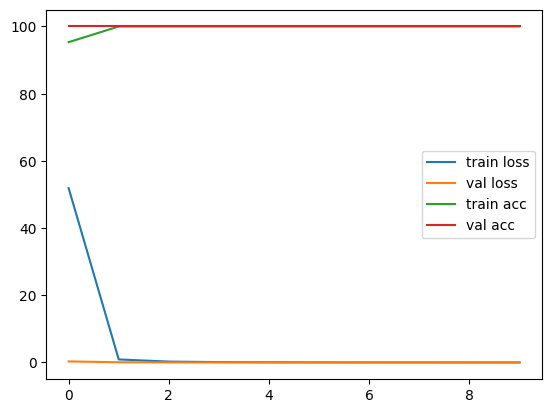

In [23]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [ ]:
model_causal = TransformerClassifier(model_config).to(device)

In [ ]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_causal.parameters(), lr=1e-6)

In [ ]:
train_loss, train_acc, val_loss, val_acc = model_causal.train_model(
    device=device,
    epochs=10,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="causal",
)

In [ ]:
test_loss, test_acc = model_causal.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="causal",
)

# Attention plots:


In [29]:
from transformer_viz.visualizer import min_max_normalize, plot_attn_matrices

In [25]:
from dataset.dataset import DyckLanguageTokenizer
from dyck_k_generator.checker import is_dyck_word

In [ ]:
batch = [
    (
        ")))))))(((((((",
        "((((((()))))))",
        ")()()()()()()(",
        "()()()()()()()"
    ),
    torch.tensor(
        [
            is_dyck_word(")))))))(((((((", 1),
            is_dyck_word("((((((()))))))", 1),
            is_dyck_word(")()()()()()()(", 1),
            is_dyck_word("()()()()()()()", 1),
        ],
        dtype=torch.float32,
        device=device,
    ),
    torch.tensor(
        [
            DyckLanguageTokenizer(VOCAB).tokenize(")))))))(((((((").tolist()[0],
            DyckLanguageTokenizer(VOCAB).tokenize("((((((()))))))").tolist()[0],
            DyckLanguageTokenizer(VOCAB).tokenize(")()()()()()()(").tolist()[0],
            DyckLanguageTokenizer(VOCAB).tokenize("()()()()()()()").tolist()[0],
        ],
        device=device,
    ),
]
batch

In [26]:
batch = next(iter(test_dataloader))

In [27]:
batch

[(')((((()(()((', '(((())))()', ')((((()(()((', '()()()()()()'),
 tensor([0., 1., 0., 1.], device='mps:0'),
 tensor([[0., 4., 3., 3., 3., 3., 3., 4., 3., 3., 4., 3., 3., 2., 1., 1., 1., 1.],
         [0., 3., 3., 3., 3., 4., 4., 4., 4., 3., 4., 2., 1., 1., 1., 1., 1., 1.],
         [0., 4., 3., 3., 3., 3., 3., 4., 3., 3., 4., 3., 3., 2., 1., 1., 1., 1.],
         [0., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 3., 4., 2., 1., 1., 1., 1.]],
        device='mps:0')]

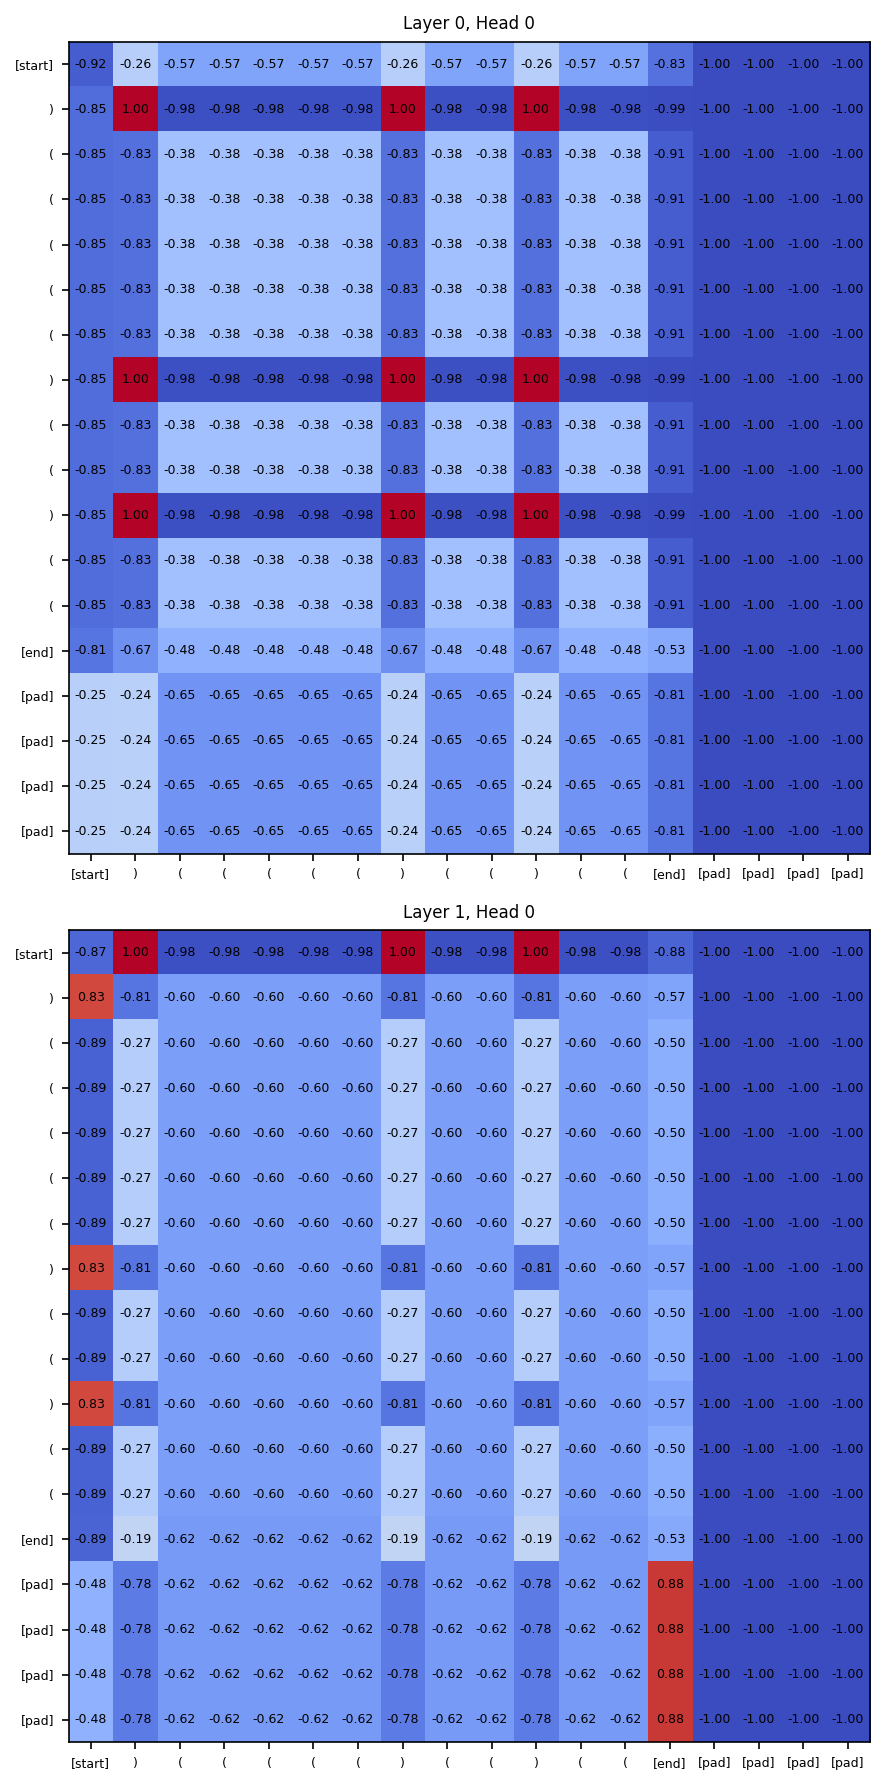

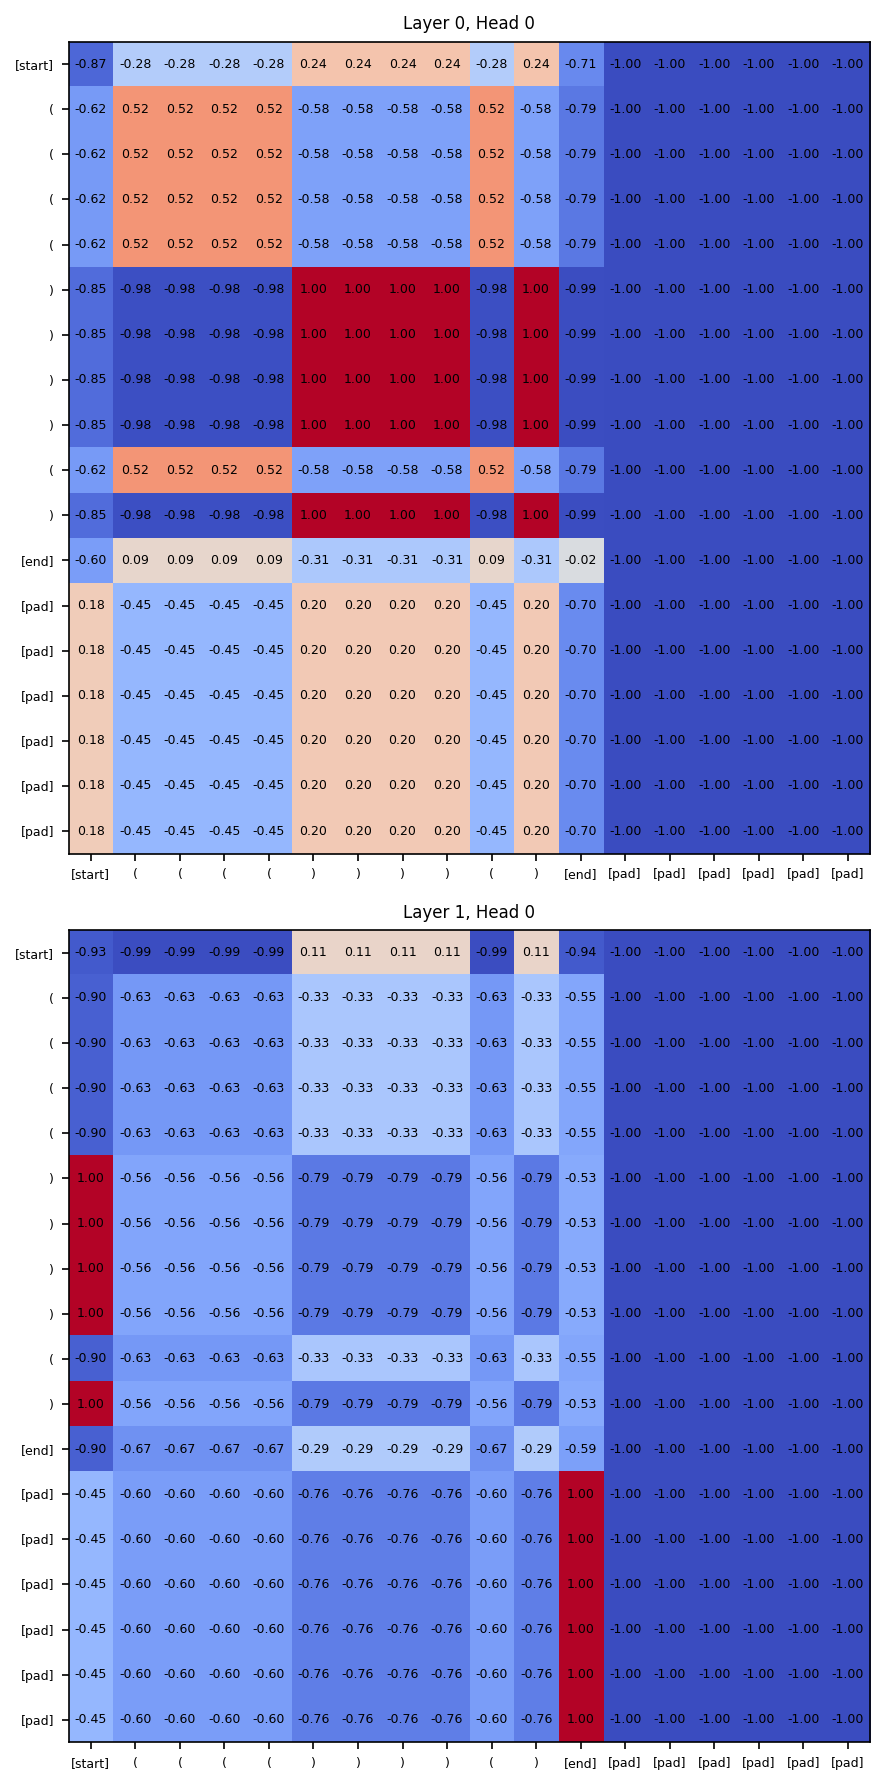

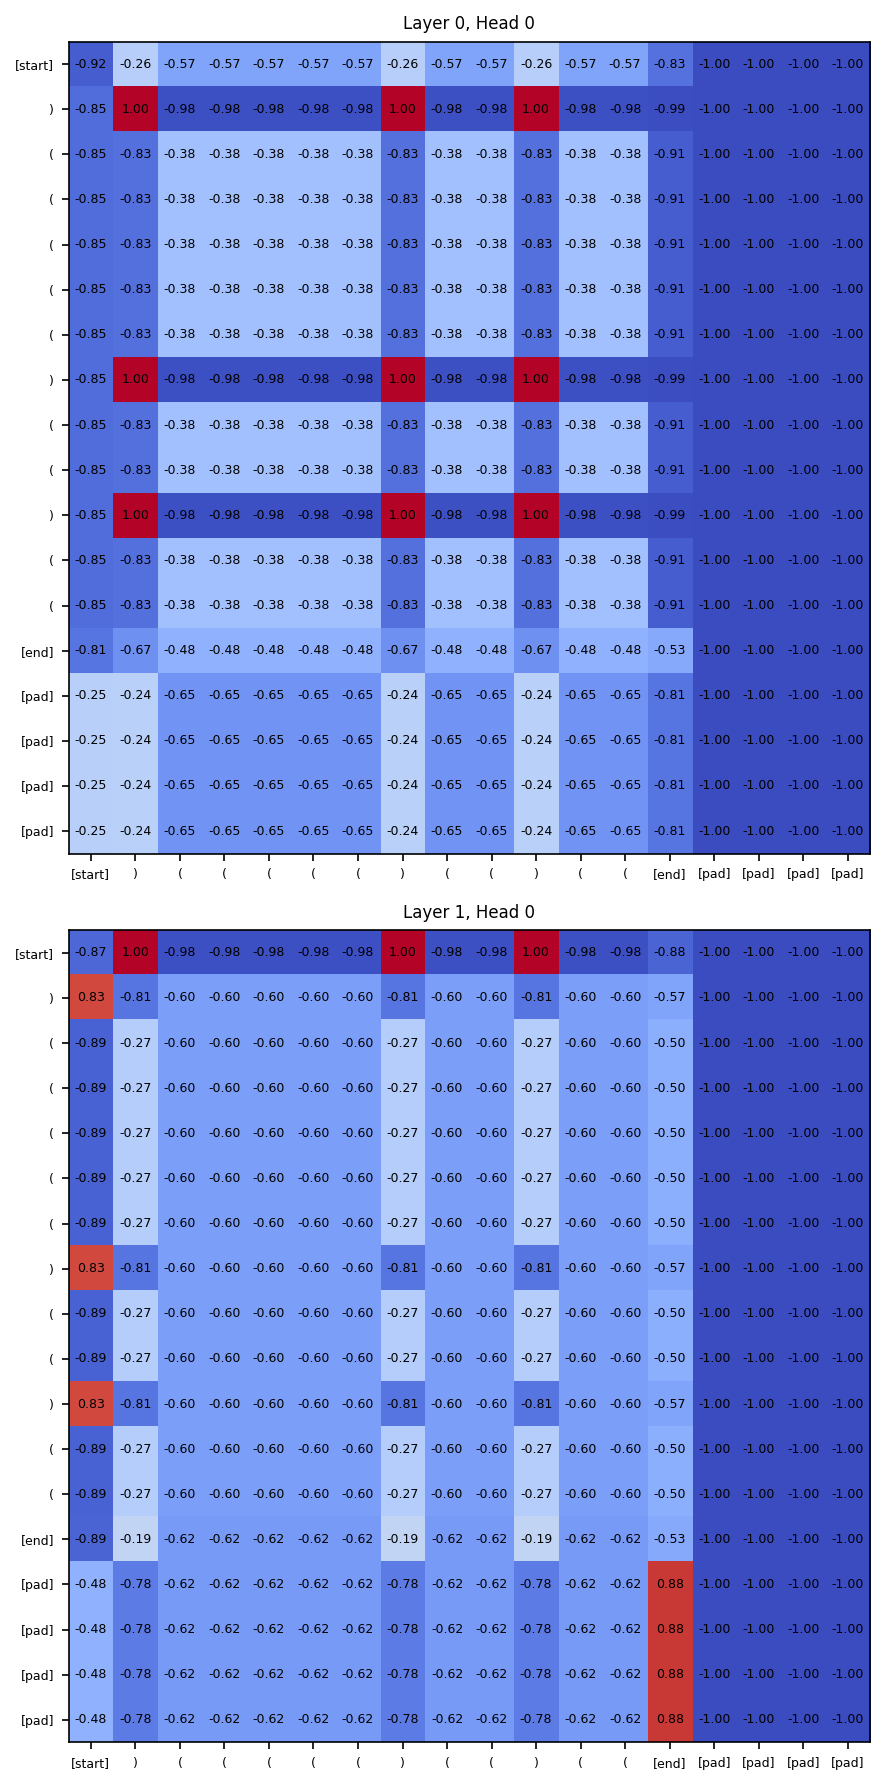

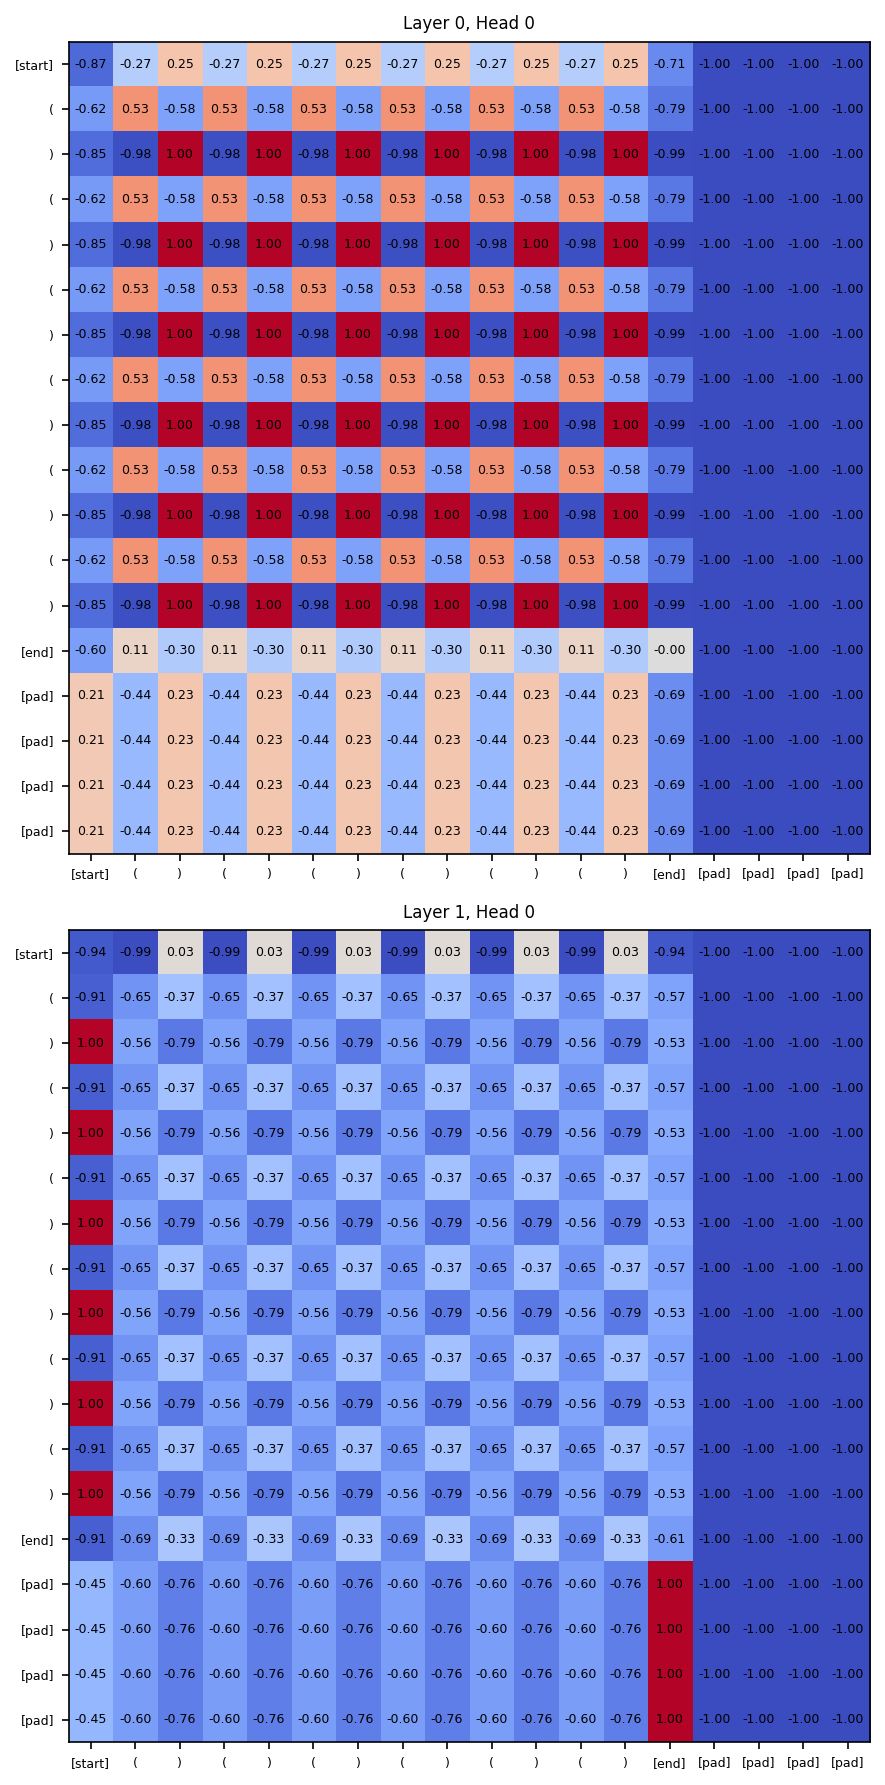

In [30]:
plot_attn_matrices(VOCAB, batch, model_bidirectional, min_max_normalize, pad_token_mask)

# Experiment 2

Dyck-3


In [32]:
k = 3

In [33]:
path = generate_dataset(
    n=15_000,
    k=3,
    min_length=0,
    max_length=16,
    balanced=0.5,
)

Generating unbalanced strings: 100%|██████████| 7500/7500 [00:00<00:00, 46832.27it/s]
Saving dataset to data/dyck-3_15000-samples_16-len_p05.jsonl: 100%|██████████| 15000/15000 [00:00<00:00, 714353.71it/s]

Dataset saved to data/dyck-3_15000-samples_16-len_p05.jsonl


In [34]:
VOCAB = "".join(["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]])
VOCAB

'()[]{}'

In [35]:
dataset_dyck_2 = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 15000 samples from data/dyck-3_15000-samples_16-len_p05.jsonl


Tokenizing strings: 100%|██████████| 15000/15000 [00:00<00:00, 639024.93it/s]


In [36]:
train_size = int(0.8 * len(dataset_dyck_2))
val_size = int(0.15 * train_size)
test_size = len(dataset_dyck_2) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset_dyck_2, [train_size, val_size, test_size])

In [37]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [38]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=512,
    n_layers=2,
    n_classes=2,
    max_seq_len=16,
)

In [39]:
model = TransformerClassifier(model_config).to(device)

In [40]:
model

TransformerClassifier(
  (embedding): Embedding(9, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=512, out_features=256, bias=True)
        )
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((2

In [41]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [42]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=15,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0838 | Train Accuracy: 92.53%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 28.2077 | Train Acc: 96.01%
Val Loss: 0.1852 | Val Acc: 100.00%
Epoch 2/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0082 | Train Accuracy: 99.98%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 1.6068 | Train Acc: 99.99%
Val Loss: 0.0415 | Val Acc: 100.00%
Epoch 3/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0027 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.5950 | Train Acc: 100.00%
Val Loss: 0.0186 | Val Acc: 100.00%
Epoch 4/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0016 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.3237 | Train Acc: 100.00%
Val Loss: 0.0102 | Val Acc: 100.00%
Epoch 5/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0014 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.2028 | Train Acc: 100.00%
Val Loss: 0.0063 | Val Acc: 100.00%
Epoch 6/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0009 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1366 | Train Acc: 100.00%
Val Loss: 0.0043 | Val Acc: 100.00%
Epoch 7/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0005 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0993 | Train Acc: 100.00%
Val Loss: 0.0032 | Val Acc: 100.00%
Epoch 8/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0743 | Train Acc: 100.00%
Val Loss: 0.0023 | Val Acc: 100.00%
Epoch 9/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 99.97%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1514 | Train Acc: 99.98%
Val Loss: 0.0020 | Val Acc: 100.00%
Epoch 10/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0490 | Train Acc: 100.00%
Val Loss: 0.0015 | Val Acc: 100.00%
Epoch 11/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0393 | Train Acc: 100.00%
Val Loss: 0.0012 | Val Acc: 100.00%
Epoch 12/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0319 | Train Acc: 100.00%
Val Loss: 0.0009 | Val Acc: 100.00%
Epoch 13/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0266 | Train Acc: 100.00%
Val Loss: 0.0008 | Val Acc: 100.00%
Epoch 14/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0226 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 15/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0194 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%


In [43]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0020 | Validation Accuracy: 100.00%
Test Loss: 0.0030 | Test Acc: 100.00%


train_acc,▁▅▆█████████████████████████████████████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,100.0
train_loss,0.00013
val_acc,100.0
val_loss,1e-05


In [44]:
batch = next(iter(test_dataloader))
batch

[('[()][]',
  ')[{[}[(}',
  ')[{[}[(}',
  ')',
  '()[[[]]]()([])',
  ')[{[}[(}',
  '[](){}[]()',
  '[]{}'),
 tensor([1., 0., 0., 0., 1., 0., 1., 1.], device='mps:0'),
 tensor([[0., 5., 3., 4., 6., 5., 6., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 4., 5., 7., 5., 8., 5., 3., 8., 2., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 4., 5., 7., 5., 8., 5., 3., 8., 2., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 4., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 3., 4., 5., 5., 5., 6., 6., 6., 3., 4., 3., 5., 6., 4., 2., 1., 1.],
         [0., 4., 5., 7., 5., 8., 5., 3., 8., 2., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 5., 6., 3., 4., 7., 8., 5., 6., 3., 4., 2., 1., 1., 1., 1., 1., 1.],
         [0., 5., 6., 7., 8., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
        device='mps:0')]

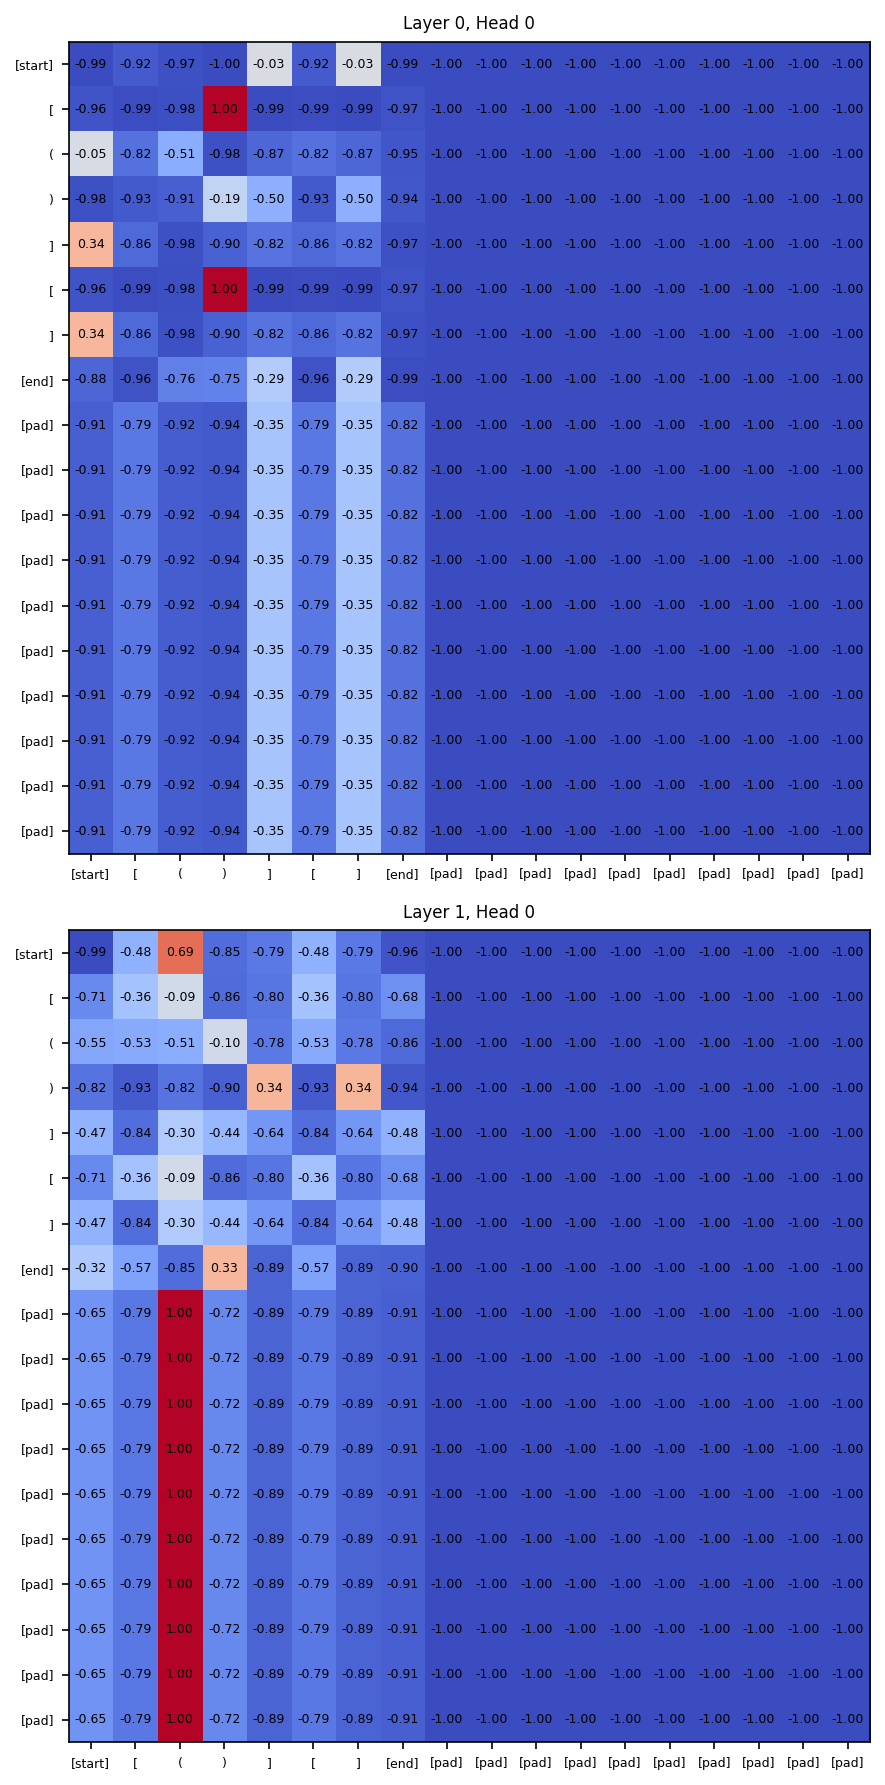

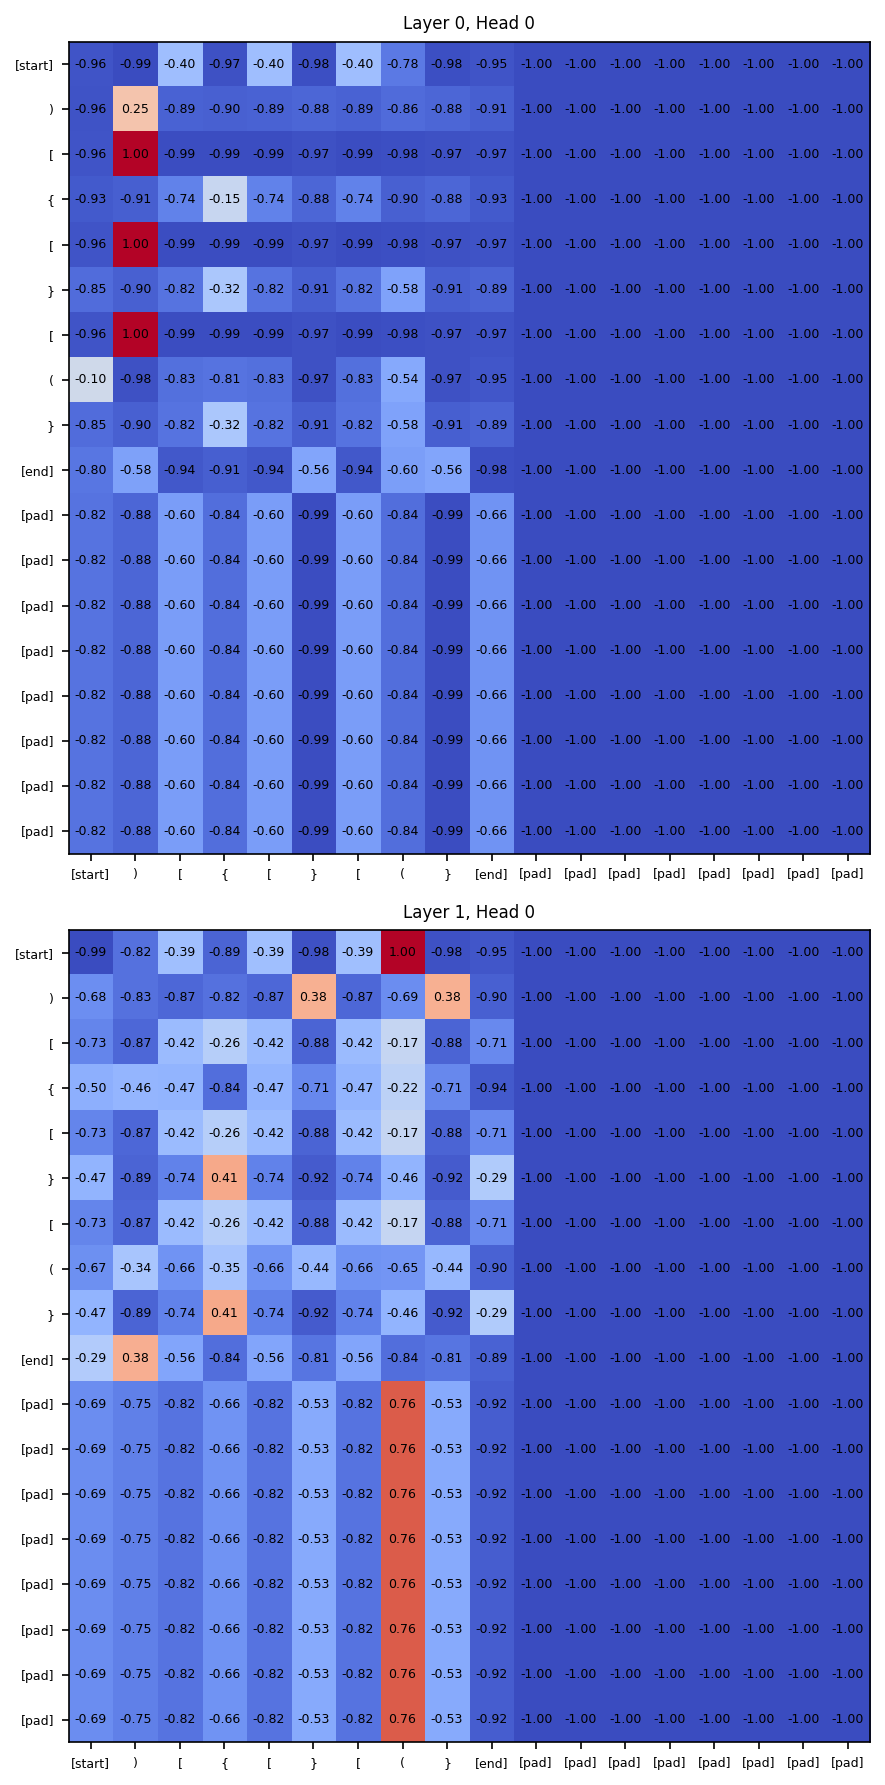

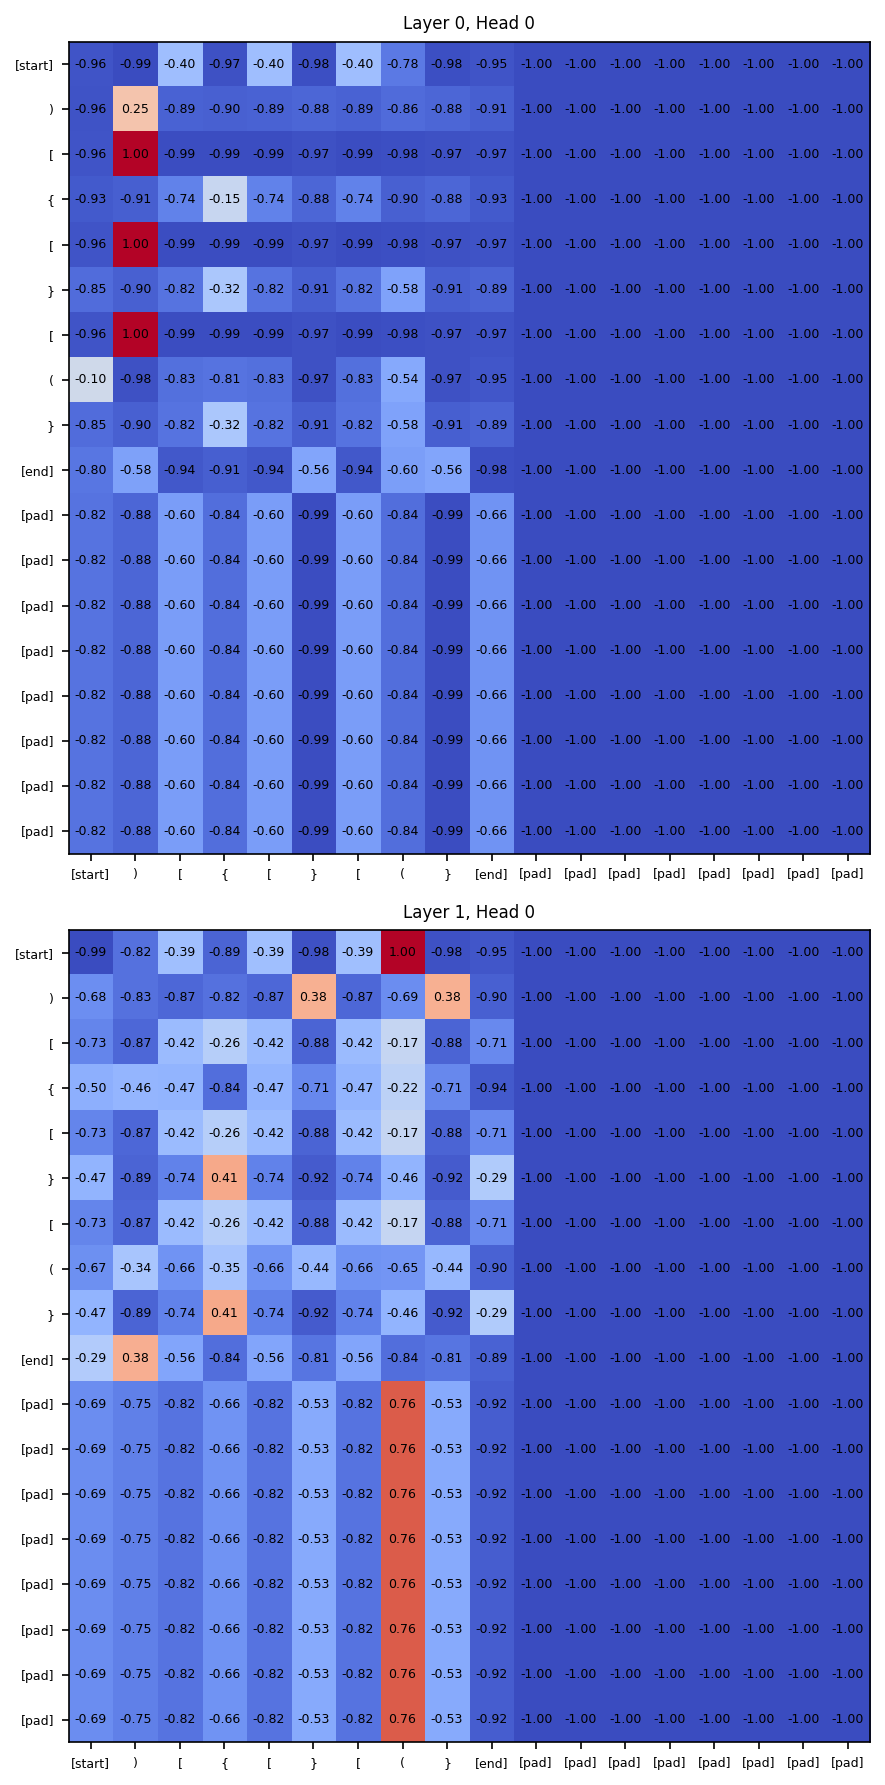

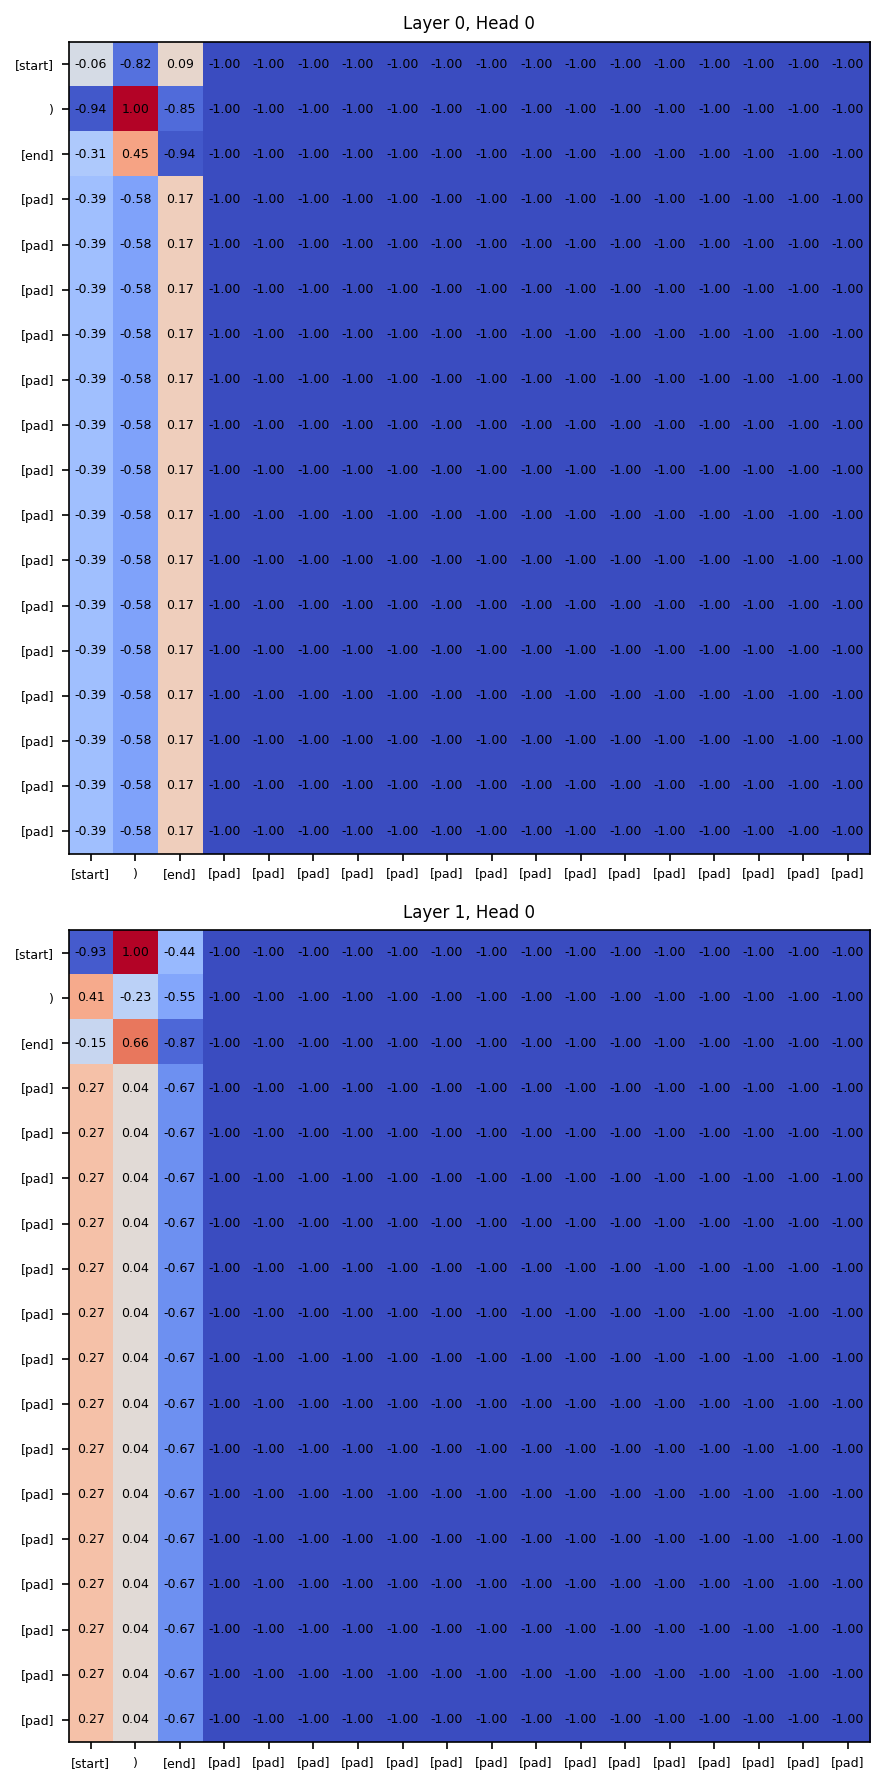

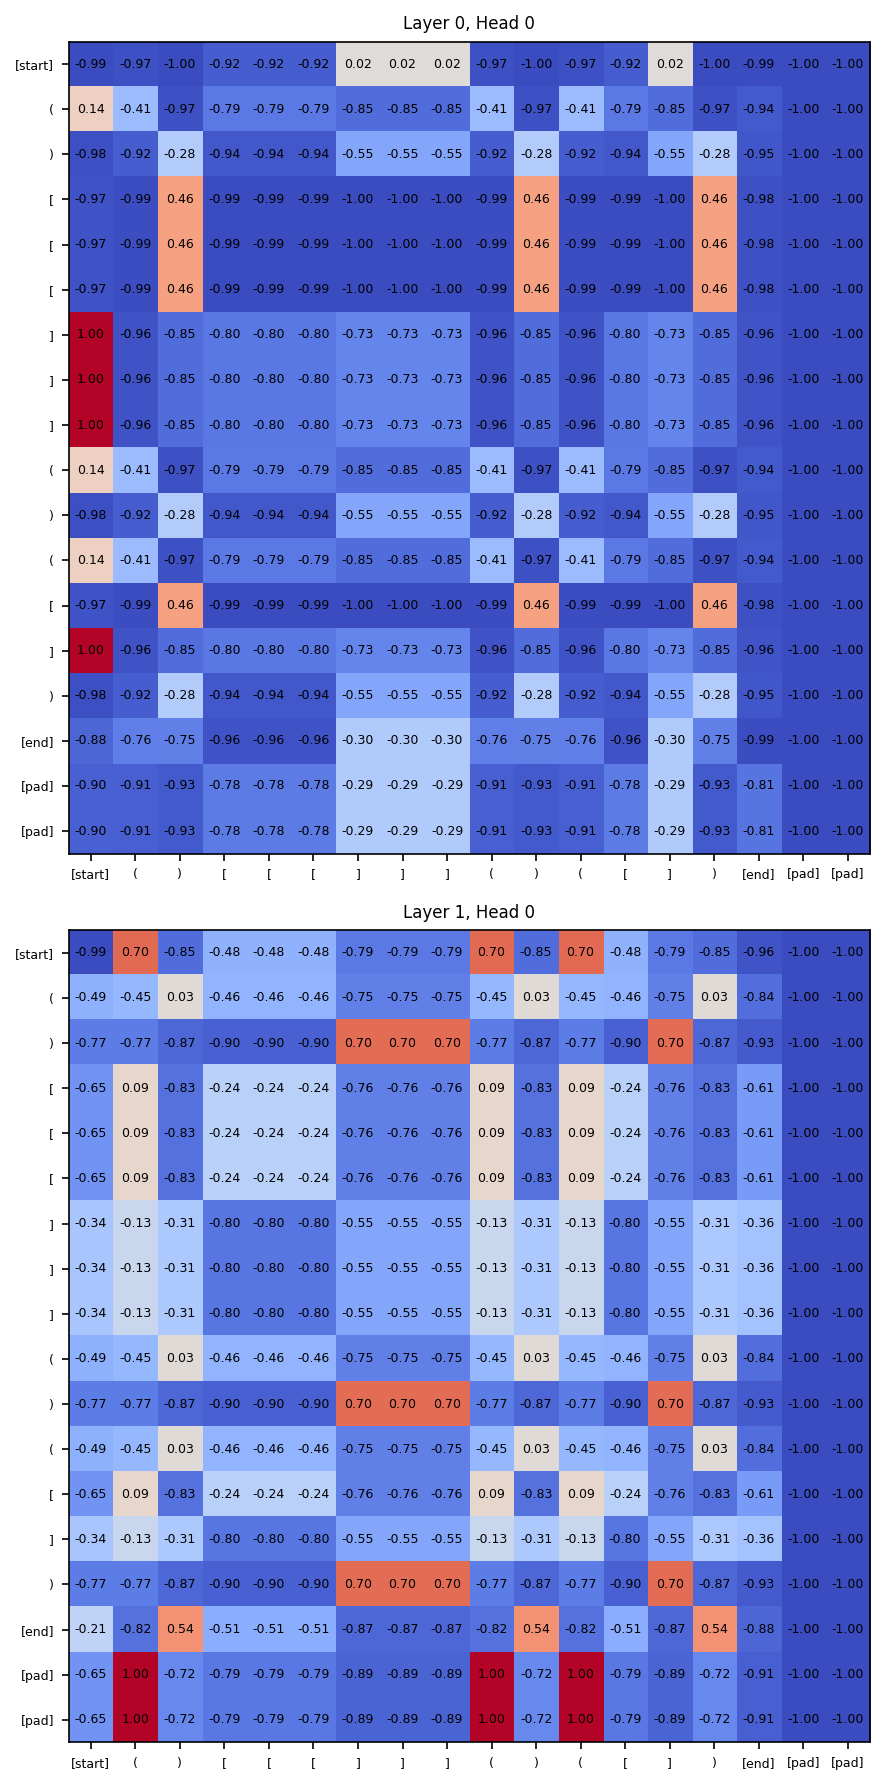

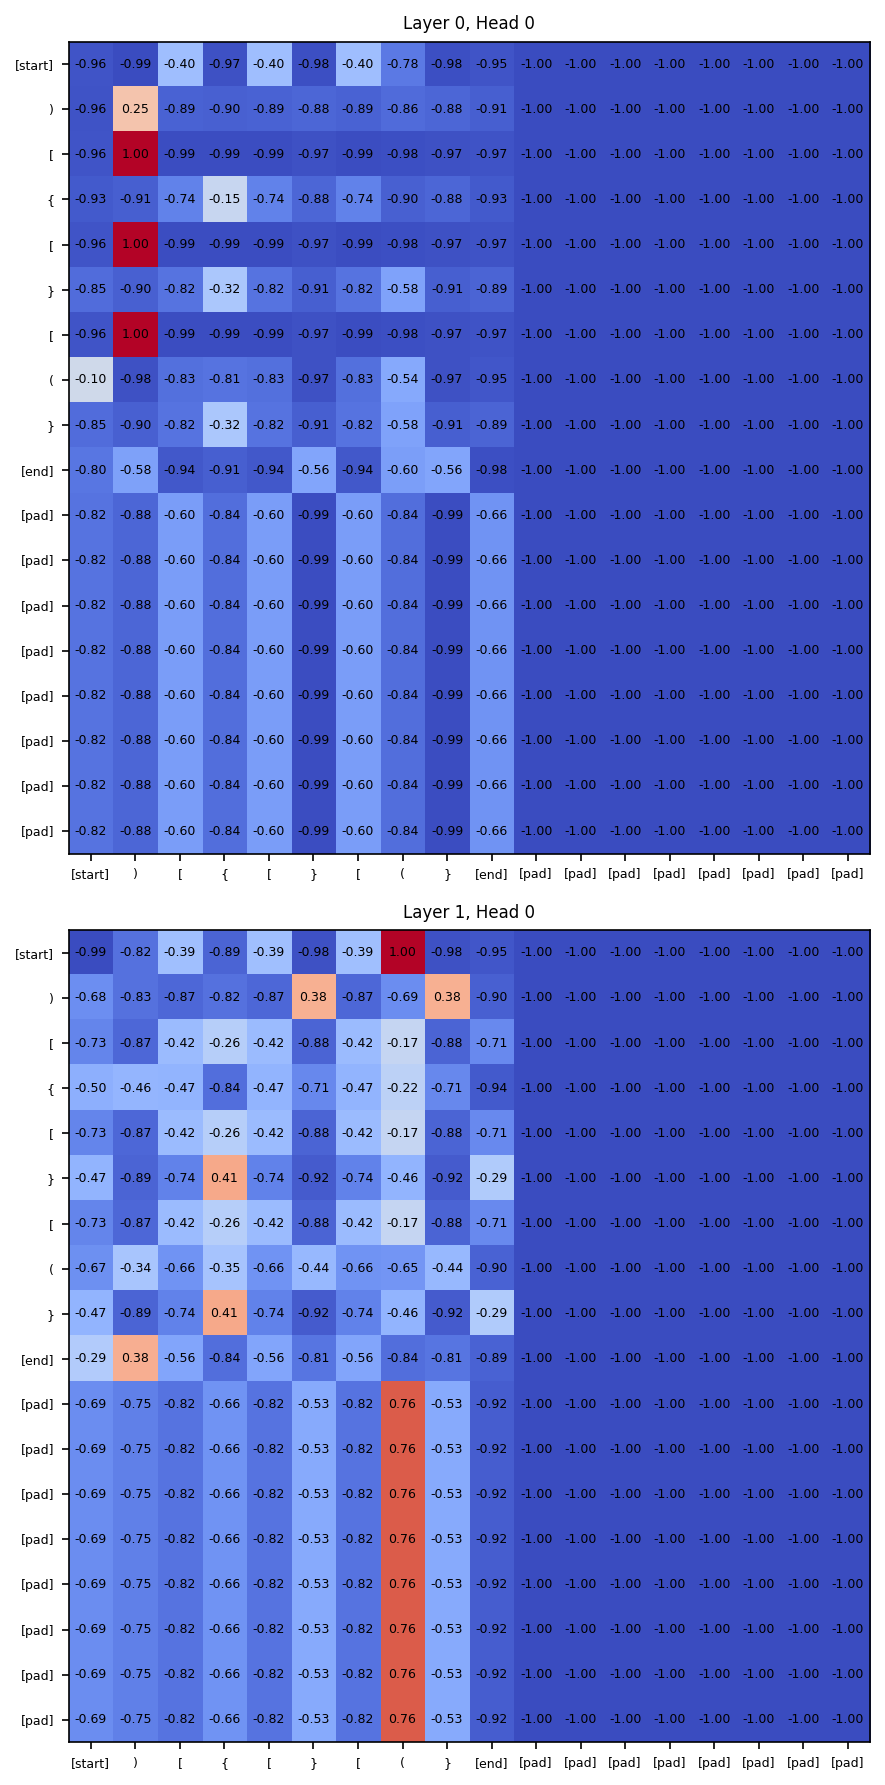

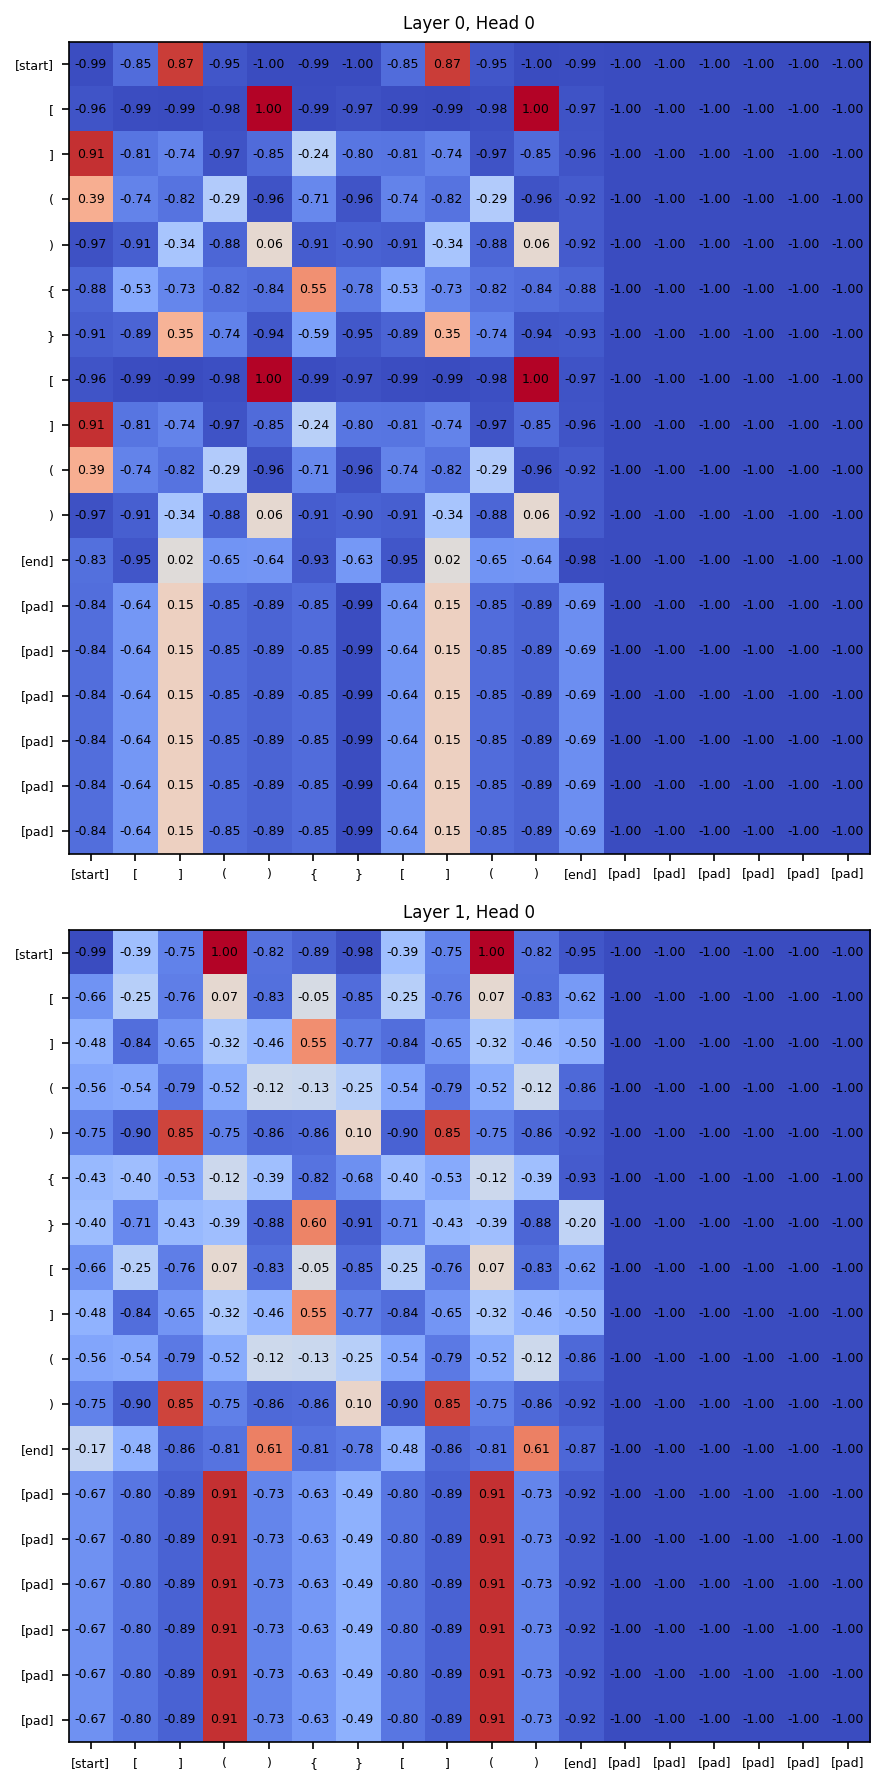

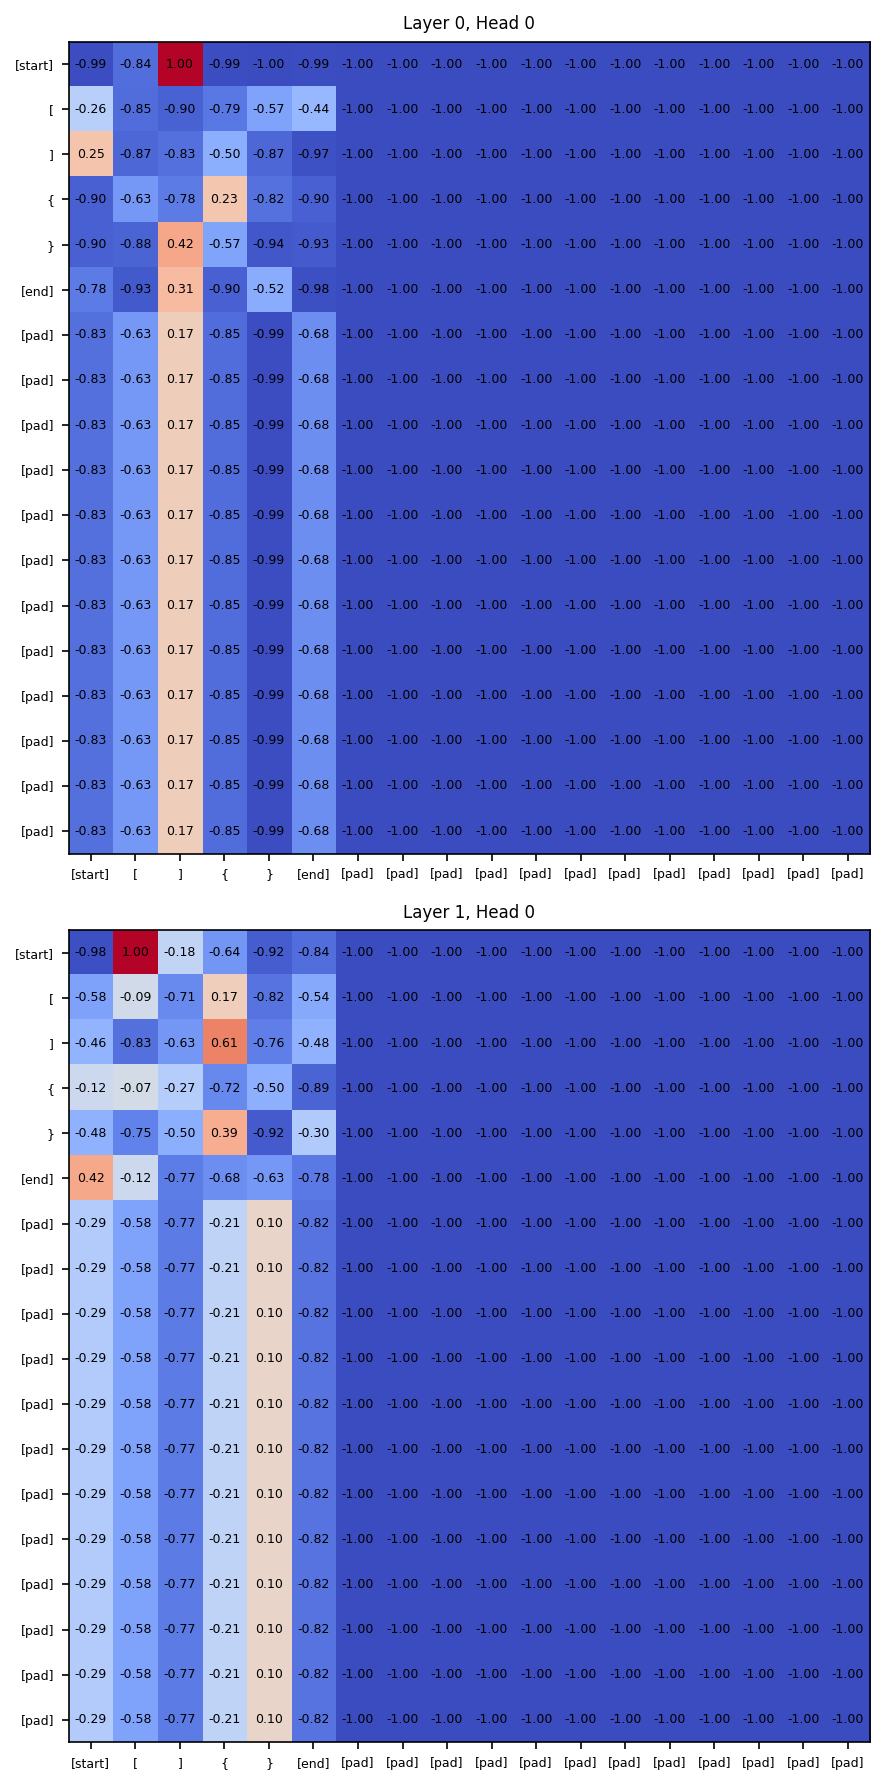

In [45]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)